<a href="https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YoloV3 TF2 GPU Colab Notebook

##### 1.  Clone and install dependencies 

**IMPORTANT**: Restart following the instruction

In [1]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 341 (delta 2), reused 1 (delta 0), pack-reused 332
Receiving objects: 100% (341/341), 4.16 MiB | 3.16 MiB/s, done.
Resolving deltas: 100% (196/196), done.
/workspace/workspace/yolo/yolo_jpt/yolov3-tf2
Obtaining file:///workspace/workspace/yolo/yolo_jpt/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
  Attempting uninstall: yolov3-tf2
    Found existing installation: yolov3-tf2 0.1
    Uninstalling yolov3-tf2-0.1:
      Successfully uninstalled yolov3-tf2-0.1
  Running setup.py develop for yolov3-tf2


##### 2.  Check Tensorflow2 version

In [1]:
%cd yolov3-tf2/
!ls

import tensorflow as tf
tf.__version__

/workspace/workspace/yolo/yolo_jpt/yolov3-tf2
checkpoints	 data		  logs			setup.py
colab_gpu.ipynb  detect.py	  output.jpg		tools
conda-cpu.yml	 detect_video.py  README.md		train.py
conda-gpu.yml	 docs		  requirements-gpu.txt	yolov3_tf2
convert.py	 LICENSE	  requirements.txt	yolov3_tf2.egg-info


'2.1.0'

In [2]:
!nvidia-smi

Mon Feb 24 07:03:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0  On |                  N/A |
| 34%   36C    P8    19W / 257W |   1026MiB / 11016MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

##### 3.  Convert Pretrained Darknet Weight

In [5]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

data/yolov3.weights: No such file or directory
python: can't open file 'convert.py': [Errno 2] No such file or directory


##### 4. Initialize Detector

In [3]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

try:

    flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
    flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                        'path to weights file')
    flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
    flags.DEFINE_integer('size', 416, 'resize images to')
    flags.DEFINE_string('image', './data/girl.png', 'path to input image')
    flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
    flags.DEFINE_string('output', './output.jpg', 'path to output image')
    flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

    app._run_init(['yolov3'], app.parse_flags_with_usage)

except:
    for name in list(flags.FLAGS):
          delattr(flags.FLAGS,name)

    flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
    flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                        'path to weights file')
    flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
    flags.DEFINE_integer('size', 416, 'resize images to')
    flags.DEFINE_string('image', './data/girl.png', 'path to input image')
    flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
    flags.DEFINE_string('output', './output.jpg', 'path to output image')
    flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

    app._run_init(['yolov3'], app.parse_flags_with_usage)
    
    
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### 4. Detect Image

##### xml to csv

In [26]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    for directory in ['train','test']:
        image_path = os.path.join(os.getcwd(), 'images/{}'.format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('./data/object-detection/csv/{}_labels.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')

main()

Successfully converted xml to csv.
Successfully converted xml to csv.


##### Creat train.txt, trainval.txt

In [9]:
import random
import os
import sys


data_path = './yolov3-tf2//data/4k_data_raw'
seed_imgs = 'JPEGImages/'
seed_labels = 'Annotations'

seed_imgs_path = os.path.join(data_path, seed_imgs)


# test 데이터 나눌 필요 있을 때 사용
#try:
#    if not(os.path.isdir('./4k_data_raw/test')):
#        os.makedirs(os.path.join('./4k_data_raw/test'))
#except OSError as e:
#    if e.errno != errno.EEXIST:
#        raise

# path 수정 해야함
for file in ['train.txt', 'val.txt', 'trainval.txt']:
    if os.path.isfile(file):
        os.remove(file)


comb_list = sorted(os.listdir(seed_imgs_path))  # trainval
#label_list = sorted(os.listdir(label_path))
cnt = int(len(comb_list) * 0.1)

random_list = random.sample(comb_list, cnt)   # val
train_list = list(set(comb_list) - set(random_list))  # train



for train_file in train_list:
    filename, ext = train_file.split('.')
    with open ('train.txt', 'a') as f:
        f.write('{}\n'.format(str(filename)))

for val_file in random_list:
    filename, ext = val_file.split('.')
    with open ('val.txt', 'a') as f:
        f.write('{}\n'.format(str(filename)))

for trainval_file in comb_list:
    filename, ext = trainval_file.split('.')
    with open ('trainval.txt', 'a') as f:
        f.write('{}\n'.format(str(filename)))


AttributeError: module 'tensorflow' has no attribute 'app'

##### tfrecord 파일 생성

In [5]:
!python tools/voc2012.py \
  --data_dir './data/4k_data_raw' \
  --split train \
  --output_file ./data/em_train.tfrecord  # tfrecord 파일명 변경

!python tools/voc2012.py \
  --data_dir './data/4k_data_raw' \
  --split val \
  --output_file ./data/em_val.tfrecord  # tfrecord 파일명 변경

I0224 03:18:02.576368 139918760036160 voc2012.py:94] Class mapping loaded: {'vita': 0, 'lemon': 1, 'vita_drink': 2, 'bongbong': 3, 'peach': 4, 'gal_bae': 5, 'mango': 6, 'pocari': 7, 'energy_dri': 8, 'redbull': 9, 'aqua': 10, 'sol': 11, 'coffee': 12}
I0224 03:18:02.576622 139918760036160 voc2012.py:99] Image list loaded: 180
100%|████████████████████████████████████████| 180/180 [00:00<00:00, 359.74it/s]
I0224 03:18:03.495538 139918760036160 voc2012.py:110] Done
I0224 03:18:05.584379 139761668167488 voc2012.py:94] Class mapping loaded: {'vita': 0, 'lemon': 1, 'vita_drink': 2, 'bongbong': 3, 'peach': 4, 'gal_bae': 5, 'mango': 6, 'pocari': 7, 'energy_dri': 8, 'redbull': 9, 'aqua': 10, 'sol': 11, 'coffee': 12}
I0224 03:18:05.584641 139761668167488 voc2012.py:99] Image list loaded: 20
100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 352.09it/s]
I0224 03:18:05.699384 139761668167488 voc2012.py:110] Done


##### class 확인하기

In [28]:
!python tools/visualize_dataset.py --dataset ./data/em_train.tfrecord --classes=./data/em_data.names

I0224 06:05:38.581358 140254637799232 visualize_dataset.py:22] classes loaded
2020-02-24 06:05:38.894403: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0224 06:05:43.639715 140254637799232 visualize_dataset.py:43] labels:
I0224 06:05:43.640533 140254637799232 visualize_dataset.py:47] 	vita, 1, [2.6041668e-04 6.3240743e-01 2.6041666e-01 8.5092592e-01]
I0224 06:05:43.640997 140254637799232 visualize_dataset.py:47] 	lemon, 1, [0.06640625 0.5037037  0.31458333 0.6259259 ]
I0224 06:05:43.641503 140254637799232 visualize_dataset.py:47] 	vita_drink, 1, [0.134375   0.4125     0.33255208 0.49351853]
I0224 06:05:43.642029 140254637799232 visualize_dataset.py:47] 	vita_drink, 1, [0.18802084 0.33657408 0.35520834 0.4097222 ]
I0224 06:05:43.642518 140254637799232 visualize_dataset.py:47] 	bongbong, 1, [0.21770833 0.25416666 0.3658854  0.33240741]
I0224 06:

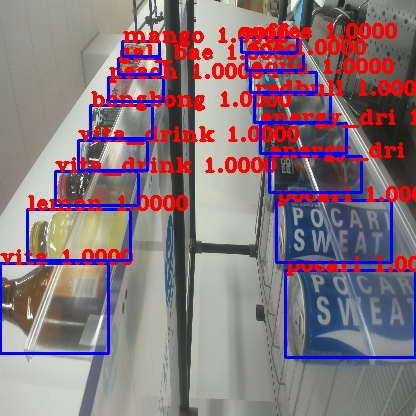

In [29]:
from IPython.display import Image
Image(filename='./output.jpg')

##### training 시작 

In [6]:
!python train.py \
	--dataset ./data/em_train.tfrecord \
	--val_dataset ./data/em_val.tfrecord \
	--classes ./data/em_data.names \
	--num_classes 13 \
	--mode fit --transfer darknet \
	--batch_size 8 \
	--epochs 10000 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

W0224 07:28:14.086933 140056177862464 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.
Epoch 1/10000
2020-02-24 07:28:28.158530: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1307] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2020-02-24 07:28:28.160823: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1346] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
      1/Unknown - 13s 13s/step - loss: 8534.5879 - yolo_output_0_loss: 320.6799 - yolo_output_1_loss: 1880.2207 - yolo_output_2_loss: 6323.02252020-02-24 07:28:28.282726: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1329] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with er

22/23 [===========================>..] - ETA: 0s - loss: 57.1962 - yolo_output_0_loss: 3.6945 - yolo_output_1_loss: 5.5734 - yolo_output_2_loss: 36.97542020-02-24 07:29:42.496741: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:29:42.496809: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 366ms/step - loss: 57.0206 - yolo_output_0_loss: 3.6494 - yolo_output_1_loss: 5.5760 - yolo_output_2_loss: 36.8388 - val_loss: 114.4684 - val_yolo_output_0_loss: 10.6923 - val_yolo_output_1_loss: 12.9812 - val_yolo_output_2_loss: 79.8415
Epoch 10/10000
22/23 [===========================>..] - ETA: 0s - loss: 49.9598 - yolo_output_0_loss: 2.7203 - yolo_output_1_loss: 4.9360 - yolo_output_2_loss: 3

23/23 [==============================] - 8s 358ms/step - loss: 26.1936 - yolo_output_0_loss: 0.8484 - yolo_output_1_loss: 2.1493 - yolo_output_2_loss: 12.2419 - val_loss: 37.0576 - val_yolo_output_0_loss: 3.0853 - val_yolo_output_1_loss: 4.7793 - val_yolo_output_2_loss: 18.2388
Epoch 19/10000
22/23 [===========================>..] - ETA: 0s - loss: 24.9135 - yolo_output_0_loss: 0.8074 - yolo_output_1_loss: 1.9316 - yolo_output_2_loss: 11.22062020-02-24 07:31:06.336434: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:31:06.336566: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 9s 371ms/step - loss: 24.8755 - yolo_output_0_loss: 0.7971 - yolo_output_1_loss: 1.9232 - yolo_output_2_loss

22/23 [===========================>..] - ETA: 0s - loss: 17.9226 - yolo_output_0_loss: 0.5690 - yolo_output_1_loss: 0.9751 - yolo_output_2_loss: 5.43402020-02-24 07:32:29.867185: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:32:29.867255: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 367ms/step - loss: 17.9263 - yolo_output_0_loss: 0.5930 - yolo_output_1_loss: 0.9714 - yolo_output_2_loss: 5.4175 - val_loss: 26.6156 - val_yolo_output_0_loss: 1.7815 - val_yolo_output_1_loss: 4.1848 - val_yolo_output_2_loss: 9.7055
Epoch 30/10000
22/23 [===========================>..] - ETA: 0s - loss: 17.6654 - yolo_output_0_loss: 0.5762 - yolo_output_1_loss: 0.9869 - yolo_output_2_loss: 5.15912

22/23 [===========================>..] - ETA: 0s - loss: 14.8986 - yolo_output_0_loss: 0.2061 - yolo_output_1_loss: 0.5541 - yolo_output_2_loss: 3.20912020-02-24 07:33:54.122591: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:33:54.122647: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 363ms/step - loss: 14.9309 - yolo_output_0_loss: 0.2453 - yolo_output_1_loss: 0.5542 - yolo_output_2_loss: 3.2028 - val_loss: 24.6343 - val_yolo_output_0_loss: 1.8794 - val_yolo_output_1_loss: 4.1196 - val_yolo_output_2_loss: 7.7070
Epoch 40/10000
22/23 [===========================>..] - ETA: 0s - loss: 14.8013 - yolo_output_0_loss: 0.2682 - yolo_output_1_loss: 0.5873 - yolo_output_2_loss: 3.01842

22/23 [===========================>..] - ETA: 0s - loss: 13.7245 - yolo_output_0_loss: 0.3373 - yolo_output_1_loss: 0.4036 - yolo_output_2_loss: 2.07512020-02-24 07:35:17.347487: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:35:17.347543: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 355ms/step - loss: 13.7172 - yolo_output_0_loss: 0.3308 - yolo_output_1_loss: 0.4041 - yolo_output_2_loss: 2.0736 - val_loss: 23.4764 - val_yolo_output_0_loss: 2.1185 - val_yolo_output_1_loss: 3.9911 - val_yolo_output_2_loss: 6.4595
Epoch 50/10000
22/23 [===========================>..] - ETA: 0s - loss: 13.5104 - yolo_output_0_loss: 0.1861 - yolo_output_1_loss: 0.3837 - yolo_output_2_loss: 2.03432

22/23 [===========================>..] - ETA: 0s - loss: 12.7632 - yolo_output_0_loss: 0.0868 - yolo_output_1_loss: 0.3391 - yolo_output_2_loss: 1.45462020-02-24 07:36:40.672686: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:36:40.672801: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 357ms/step - loss: 12.7599 - yolo_output_0_loss: 0.0877 - yolo_output_1_loss: 0.3371 - yolo_output_2_loss: 1.4523 - val_loss: 23.0640 - val_yolo_output_0_loss: 2.1618 - val_yolo_output_1_loss: 3.9259 - val_yolo_output_2_loss: 6.0950
Epoch 60/10000
22/23 [===========================>..] - ETA: 0s - loss: 12.7176 - yolo_output_0_loss: 0.0978 - yolo_output_1_loss: 0.3055 - yolo_output_2_loss: 1.43452

22/23 [===========================>..] - ETA: 0s - loss: 12.2488 - yolo_output_0_loss: 0.0718 - yolo_output_1_loss: 0.2124 - yolo_output_2_loss: 1.11272020-02-24 07:38:03.405126: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:38:03.405197: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 352ms/step - loss: 12.2538 - yolo_output_0_loss: 0.0710 - yolo_output_1_loss: 0.2118 - yolo_output_2_loss: 1.1195 - val_loss: 23.2258 - val_yolo_output_0_loss: 2.4357 - val_yolo_output_1_loss: 4.1664 - val_yolo_output_2_loss: 5.7738
Epoch 70/10000
22/23 [===========================>..] - ETA: 0s - loss: 12.2126 - yolo_output_0_loss: 0.0770 - yolo_output_1_loss: 0.2120 - yolo_output_2_loss: 1.07532

22/23 [===========================>..] - ETA: 0s - loss: 11.9309 - yolo_output_0_loss: 0.0442 - yolo_output_1_loss: 0.1509 - yolo_output_2_loss: 0.89872020-02-24 07:39:26.770954: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:39:26.771017: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 369ms/step - loss: 11.9372 - yolo_output_0_loss: 0.0447 - yolo_output_1_loss: 0.1542 - yolo_output_2_loss: 0.9014 - val_loss: 22.9724 - val_yolo_output_0_loss: 2.5356 - val_yolo_output_1_loss: 4.1179 - val_yolo_output_2_loss: 5.4820
Epoch 80/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9299 - yolo_output_0_loss: 0.0444 - yolo_output_1_loss: 0.1515 - yolo_output_2_loss: 0.89752

23/23 [==============================] - 8s 357ms/step - loss: 11.9037 - yolo_output_0_loss: 0.0424 - yolo_output_1_loss: 0.1442 - yolo_output_2_loss: 0.8821 - val_loss: 23.0561 - val_yolo_output_0_loss: 2.5838 - val_yolo_output_1_loss: 4.1479 - val_yolo_output_2_loss: 5.4895
Epoch 89/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9044 - yolo_output_0_loss: 0.0429 - yolo_output_1_loss: 0.1443 - yolo_output_2_loss: 0.88232020-02-24 07:40:50.198904: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:40:50.198965: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 367ms/step - loss: 11.9036 - yolo_output_0_loss: 0.0427 - yolo_output_1_loss: 0.1441 - yolo_output_2_loss: 0

22/23 [===========================>..] - ETA: 0s - loss: 11.9010 - yolo_output_0_loss: 0.0420 - yolo_output_1_loss: 0.1438 - yolo_output_2_loss: 0.88052020-02-24 07:42:13.373851: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2020-02-24 07:42:13.373870: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
23/23 [==============================] - 8s 367ms/step - loss: 11.8999 - yolo_output_0_loss: 0.0419 - yolo_output_1_loss: 0.1435 - yolo_output_2_loss: 0.8799 - val_loss: 23.0727 - val_yolo_output_0_loss: 2.5951 - val_yolo_output_1_loss: 4.1552 - val_yolo_output_2_loss: 5.4878
Epoch 100/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8999 - yolo_output_0_loss: 0.0423 - yolo_output_1_loss: 0.1434 - yolo_output_2_loss: 0.8796

22/23 [===========================>..] - ETA: 0s - loss: 11.9000 - yolo_output_0_loss: 0.0421 - yolo_output_1_loss: 0.1438 - yolo_output_2_loss: 0.87952020-02-24 07:43:36.957902: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2020-02-24 07:43:36.957914: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
23/23 [==============================] - 8s 363ms/step - loss: 11.9005 - yolo_output_0_loss: 0.0425 - yolo_output_1_loss: 0.1439 - yolo_output_2_loss: 0.8795 - val_loss: 23.0767 - val_yolo_output_0_loss: 2.5977 - val_yolo_output_1_loss: 4.1561 - val_yolo_output_2_loss: 5.4883
Epoch 110/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9002 - yolo_output_0_loss: 0.0425 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.8797

23/23 [==============================] - 9s 370ms/step - loss: 11.8993 - yolo_output_0_loss: 0.0419 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.8795 - val_loss: 23.0760 - val_yolo_output_0_loss: 2.5970 - val_yolo_output_1_loss: 4.1560 - val_yolo_output_2_loss: 5.4883
Epoch 119/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9005 - yolo_output_0_loss: 0.0424 - yolo_output_1_loss: 0.1437 - yolo_output_2_loss: 0.87982020-02-24 07:45:00.789231: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:45:00.789294: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 358ms/step - loss: 11.8997 - yolo_output_0_loss: 0.0424 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 

22/23 [===========================>..] - ETA: 0s - loss: 11.8993 - yolo_output_0_loss: 0.0424 - yolo_output_1_loss: 0.1434 - yolo_output_2_loss: 0.87892020-02-24 07:46:25.188551: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:46:25.188602: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 357ms/step - loss: 11.9015 - yolo_output_0_loss: 0.0426 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 0.8807 - val_loss: 23.0771 - val_yolo_output_0_loss: 2.5974 - val_yolo_output_1_loss: 4.1565 - val_yolo_output_2_loss: 5.4886
Epoch 130/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9008 - yolo_output_0_loss: 0.0426 - yolo_output_1_loss: 0.1435 - yolo_output_2_loss: 0.8800

22/23 [===========================>..] - ETA: 0s - loss: 11.9006 - yolo_output_0_loss: 0.0422 - yolo_output_1_loss: 0.1439 - yolo_output_2_loss: 0.87992020-02-24 07:47:48.934321: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:47:48.934379: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 363ms/step - loss: 11.9000 - yolo_output_0_loss: 0.0419 - yolo_output_1_loss: 0.1437 - yolo_output_2_loss: 0.8797 - val_loss: 23.0767 - val_yolo_output_0_loss: 2.5975 - val_yolo_output_1_loss: 4.1564 - val_yolo_output_2_loss: 5.4882
Epoch 140/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9008 - yolo_output_0_loss: 0.0421 - yolo_output_1_loss: 0.1438 - yolo_output_2_loss: 0.8802

22/23 [===========================>..] - ETA: 0s - loss: 11.8994 - yolo_output_0_loss: 0.0420 - yolo_output_1_loss: 0.1435 - yolo_output_2_loss: 0.87922020-02-24 07:49:12.427161: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2020-02-24 07:49:12.427164: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
23/23 [==============================] - 8s 362ms/step - loss: 11.8991 - yolo_output_0_loss: 0.0422 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.8790 - val_loss: 23.0755 - val_yolo_output_0_loss: 2.5967 - val_yolo_output_1_loss: 4.1559 - val_yolo_output_2_loss: 5.4883
Epoch 150/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8999 - yolo_output_0_loss: 0.0423 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.8797

22/23 [===========================>..] - ETA: 0s - loss: 11.9002 - yolo_output_0_loss: 0.0425 - yolo_output_1_loss: 0.1434 - yolo_output_2_loss: 0.87972020-02-24 07:50:35.343614: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:50:35.343670: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 369ms/step - loss: 11.8999 - yolo_output_0_loss: 0.0425 - yolo_output_1_loss: 0.1435 - yolo_output_2_loss: 0.8792 - val_loss: 23.0768 - val_yolo_output_0_loss: 2.5979 - val_yolo_output_1_loss: 4.1561 - val_yolo_output_2_loss: 5.4881
Epoch 160/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9005 - yolo_output_0_loss: 0.0426 - yolo_output_1_loss: 0.1439 - yolo_output_2_loss: 0.8793

22/23 [===========================>..] - ETA: 0s - loss: 11.8996 - yolo_output_0_loss: 0.0419 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.87982020-02-24 07:51:58.787582: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:51:58.787639: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 363ms/step - loss: 11.8984 - yolo_output_0_loss: 0.0417 - yolo_output_1_loss: 0.1430 - yolo_output_2_loss: 0.8791 - val_loss: 23.0764 - val_yolo_output_0_loss: 2.5979 - val_yolo_output_1_loss: 4.1559 - val_yolo_output_2_loss: 5.4879
Epoch 170/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8993 - yolo_output_0_loss: 0.0416 - yolo_output_1_loss: 0.1434 - yolo_output_2_loss: 0.8797

22/23 [===========================>..] - ETA: 0s - loss: 11.8984 - yolo_output_0_loss: 0.0420 - yolo_output_1_loss: 0.1434 - yolo_output_2_loss: 0.87832020-02-24 07:53:21.954101: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:53:21.954154: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 356ms/step - loss: 11.9007 - yolo_output_0_loss: 0.0421 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 0.8804 - val_loss: 23.0776 - val_yolo_output_0_loss: 2.5981 - val_yolo_output_1_loss: 4.1566 - val_yolo_output_2_loss: 5.4882
Epoch 180/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9007 - yolo_output_0_loss: 0.0423 - yolo_output_1_loss: 0.1438 - yolo_output_2_loss: 0.8800

23/23 [==============================] - 8s 367ms/step - loss: 11.9007 - yolo_output_0_loss: 0.0429 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 0.8796 - val_loss: 23.0773 - val_yolo_output_0_loss: 2.5981 - val_yolo_output_1_loss: 4.1563 - val_yolo_output_2_loss: 5.4882
Epoch 189/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8997 - yolo_output_0_loss: 0.0422 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.87962020-02-24 07:54:45.976730: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:54:45.976790: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 359ms/step - loss: 11.8984 - yolo_output_0_loss: 0.0415 - yolo_output_1_loss: 0.1432 - yolo_output_2_loss: 

23/23 [==============================] - 8s 364ms/step - loss: 11.8997 - yolo_output_0_loss: 0.0423 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 0.8791 - val_loss: 23.0777 - val_yolo_output_0_loss: 2.5983 - val_yolo_output_1_loss: 4.1567 - val_yolo_output_2_loss: 5.4881
Epoch 199/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8990 - yolo_output_0_loss: 0.0420 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.87912020-02-24 07:56:08.918847: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2020-02-24 07:56:08.918857: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
23/23 [==============================] - 8s 364ms/step - loss: 11.9003 - yolo_output_0_loss: 0.0427 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 

22/23 [===========================>..] - ETA: 0s - loss: 11.9007 - yolo_output_0_loss: 0.0424 - yolo_output_1_loss: 0.1438 - yolo_output_2_loss: 0.87992020-02-24 07:57:24.276225: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 07:57:24.276314: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 366ms/step - loss: 11.8993 - yolo_output_0_loss: 0.0419 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 0.8791 - val_loss: 23.0764 - val_yolo_output_0_loss: 2.5973 - val_yolo_output_1_loss: 4.1564 - val_yolo_output_2_loss: 5.4880
Epoch 209/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8999 - yolo_output_0_loss: 0.0421 - yolo_output_1_loss: 0.1437 - yolo_output_2_loss: 0.8795

22/23 [===========================>..] - ETA: 0s - loss: 11.8999 - yolo_output_0_loss: 0.0421 - yolo_output_1_loss: 0.1434 - yolo_output_2_loss: 0.87982020-02-24 07:58:47.885648: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2020-02-24 07:58:47.885676: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
23/23 [==============================] - 8s 364ms/step - loss: 11.8996 - yolo_output_0_loss: 0.0421 - yolo_output_1_loss: 0.1432 - yolo_output_2_loss: 0.8797 - val_loss: 23.0763 - val_yolo_output_0_loss: 2.5972 - val_yolo_output_1_loss: 4.1563 - val_yolo_output_2_loss: 5.4883
Epoch 219/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8999 - yolo_output_0_loss: 0.0422 - yolo_output_1_loss: 0.1435 - yolo_output_2_loss: 0.8796

22/23 [===========================>..] - ETA: 0s - loss: 11.9003 - yolo_output_0_loss: 0.0422 - yolo_output_1_loss: 0.1440 - yolo_output_2_loss: 0.87952020-02-24 08:00:11.123834: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 08:00:11.123886: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 9s 373ms/step - loss: 11.9009 - yolo_output_0_loss: 0.0424 - yolo_output_1_loss: 0.1439 - yolo_output_2_loss: 0.8800 - val_loss: 23.0751 - val_yolo_output_0_loss: 2.5968 - val_yolo_output_1_loss: 4.1557 - val_yolo_output_2_loss: 5.4880
Epoch 229/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8992 - yolo_output_0_loss: 0.0414 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.8799

22/23 [===========================>..] - ETA: 0s - loss: 11.8994 - yolo_output_0_loss: 0.0428 - yolo_output_1_loss: 0.1435 - yolo_output_2_loss: 0.87852020-02-24 08:01:34.432716: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2020-02-24 08:01:34.432724: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
23/23 [==============================] - 8s 357ms/step - loss: 11.9008 - yolo_output_0_loss: 0.0421 - yolo_output_1_loss: 0.1434 - yolo_output_2_loss: 0.8807 - val_loss: 23.0769 - val_yolo_output_0_loss: 2.5974 - val_yolo_output_1_loss: 4.1565 - val_yolo_output_2_loss: 5.4884
Epoch 239/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8992 - yolo_output_0_loss: 0.0424 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.8789

22/23 [===========================>..] - ETA: 0s - loss: 11.8999 - yolo_output_0_loss: 0.0422 - yolo_output_1_loss: 0.1435 - yolo_output_2_loss: 0.87962020-02-24 08:02:57.385097: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2020-02-24 08:02:57.385112: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
23/23 [==============================] - 8s 360ms/step - loss: 11.9004 - yolo_output_0_loss: 0.0423 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 0.8799 - val_loss: 23.0750 - val_yolo_output_0_loss: 2.5966 - val_yolo_output_1_loss: 4.1556 - val_yolo_output_2_loss: 5.4881
Epoch 249/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9001 - yolo_output_0_loss: 0.0423 - yolo_output_1_loss: 0.1435 - yolo_output_2_loss: 0.8797

22/23 [===========================>..] - ETA: 0s - loss: 11.8996 - yolo_output_0_loss: 0.0417 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 0.87972020-02-24 08:04:20.583225: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 08:04:20.583278: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 365ms/step - loss: 11.9007 - yolo_output_0_loss: 0.0429 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 0.8795 - val_loss: 23.0752 - val_yolo_output_0_loss: 2.5972 - val_yolo_output_1_loss: 4.1557 - val_yolo_output_2_loss: 5.4877
Epoch 259/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.8991 - yolo_output_0_loss: 0.0420 - yolo_output_1_loss: 0.1433 - yolo_output_2_loss: 0.8791

22/23 [===========================>..] - ETA: 0s - loss: 11.9007 - yolo_output_0_loss: 0.0425 - yolo_output_1_loss: 0.1436 - yolo_output_2_loss: 0.88002020-02-24 08:05:43.573531: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2020-02-24 08:05:43.573577: W tensorflow/core/common_runtime/base_collective_executor.cc:217] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
23/23 [==============================] - 8s 360ms/step - loss: 11.9001 - yolo_output_0_loss: 0.0425 - yolo_output_1_loss: 0.1435 - yolo_output_2_loss: 0.8794 - val_loss: 23.0754 - val_yolo_output_0_loss: 2.5968 - val_yolo_output_1_loss: 4.1560 - val_yolo_output_2_loss: 5.4880
Epoch 269/10000
22/23 [===========================>..] - ETA: 0s - loss: 11.9001 - yolo_output_0_loss: 0.0420 - yolo_output_1_loss: 0.1437 - yolo_output_2_loss: 0.8799

##### 6. Detect using new weights

I0224 08:12:16.553197 139776071984960 <ipython-input-8-fbe89a592de5>:16] weights loaded
I0224 08:12:16.553954 139776071984960 <ipython-input-8-fbe89a592de5>:19] classes loaded
I0224 08:12:16.701417 139776071984960 <ipython-input-8-fbe89a592de5>:30] time: 0.11870312690734863
I0224 08:12:16.701903 139776071984960 <ipython-input-8-fbe89a592de5>:32] detections:
I0224 08:12:16.704117 139776071984960 <ipython-input-8-fbe89a592de5>:36] 	pocari, 0.5987101197242737, [0.68612874 0.6765666  0.98286664 0.8690436 ]
I0224 08:12:16.705852 139776071984960 <ipython-input-8-fbe89a592de5>:36] 	energy_dri, 0.3495088815689087, [0.66860247 0.3843035  0.8612505  0.48523515]
I0224 08:12:16.707767 139776071984960 <ipython-input-8-fbe89a592de5>:36] 	energy_dri, 0.24168509244918823, [0.6188491  0.29307577 0.836858   0.36938098]
I0224 08:12:16.709751 139776071984960 <ipython-input-8-fbe89a592de5>:36] 	vita_drink, 0.220089852809906, [0.16861793 0.32463518 0.36348394 0.40573665]


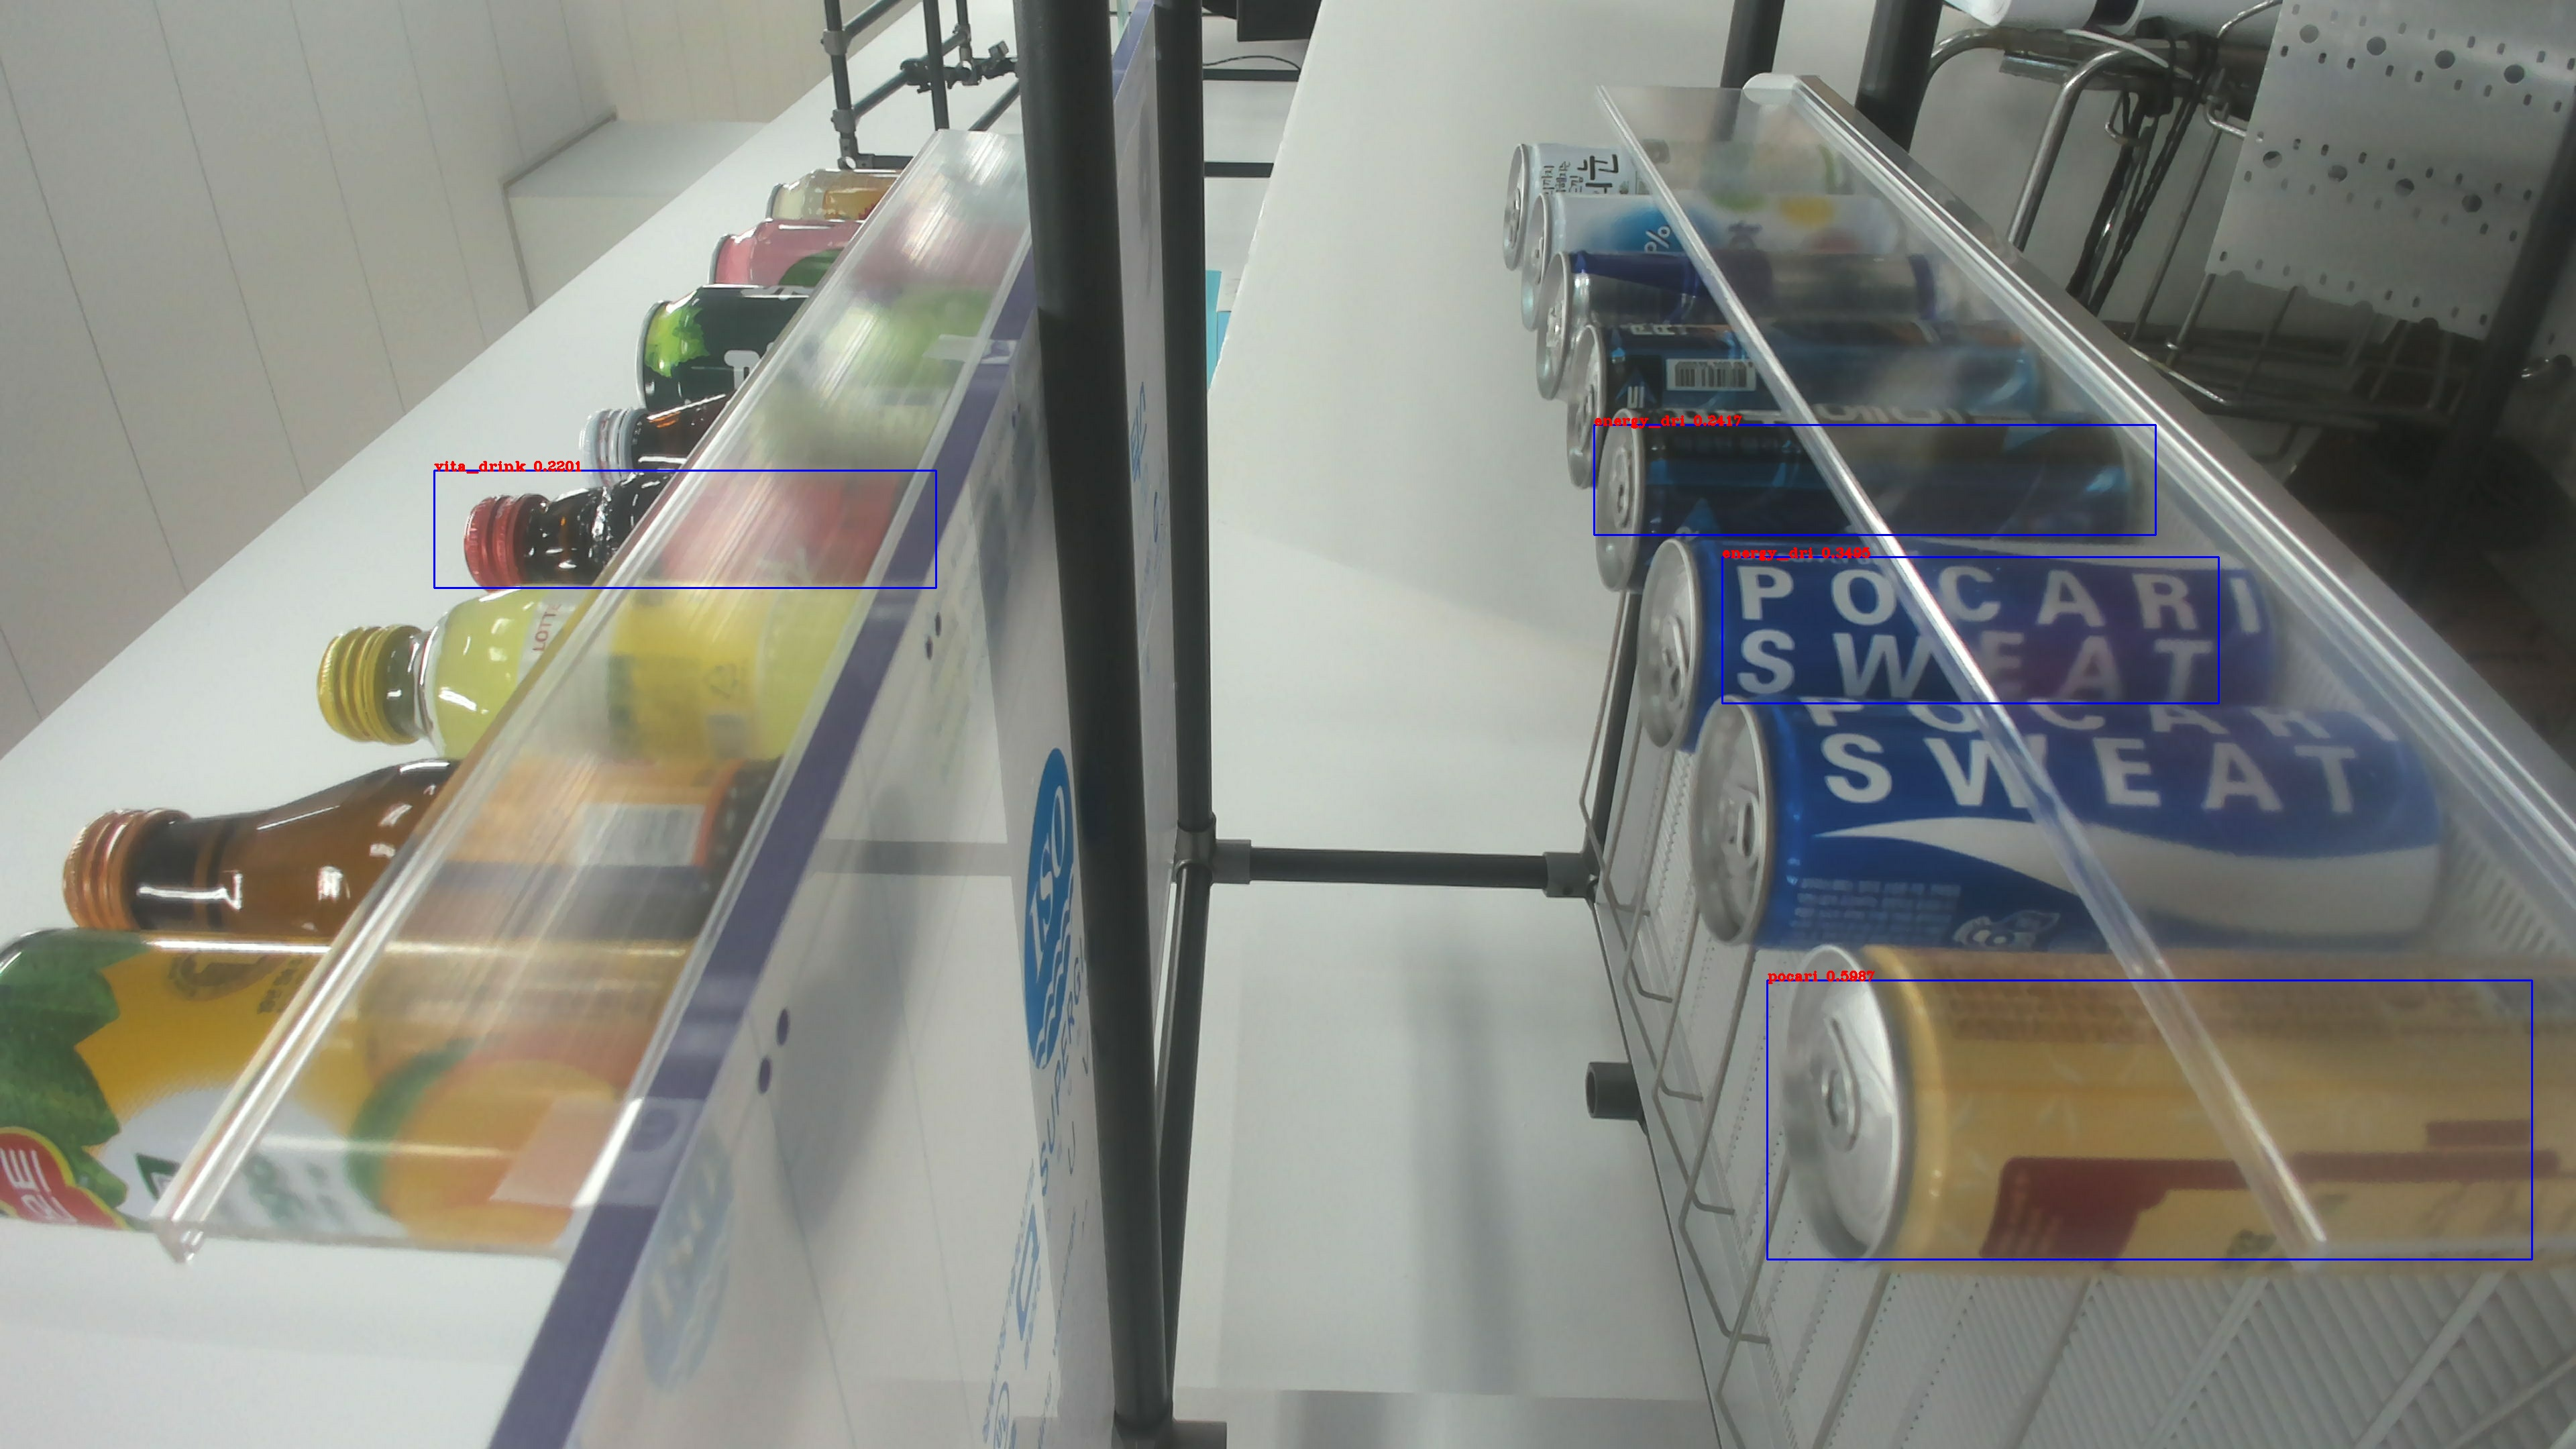

In [8]:
FLAGS.num_classes = 13
FLAGS.classes = 'data/em_data.names'
FLAGS.weights = 'checkpoints/yolov3_train_200.tf'
FLAGS.image = 'data/4k_data_raw/Test/3.jpg'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=1000))